# Beef Cattle Muzzle: MobileNetV3 Full Fine-tune (Paper Comparison)

Architecture for comparison:
- Input: 224x224
- MobileNetV3 backbone
- Global Average Pooling
- FC: 576 -> 268
- Softmax (implemented via CrossEntropyLoss)

This notebook follows the same step-style structure as your current experiment notebook.


In [1]:
# ========== Step 1: imports + config ==========
import os
import random
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models

from sklearn.metrics import accuracy_score, f1_score

# Thread setup
os.environ.setdefault('OMP_NUM_THREADS', '16')
os.environ.setdefault('MKL_NUM_THREADS', '16')
os.environ.setdefault('OPENBLAS_NUM_THREADS', '16')
os.environ.setdefault('NUMEXPR_NUM_THREADS', '16')

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

CFG = {
    'seed': 42,
    'root': Path('.').resolve(),
    'data_manifest': Path('data/manifest_usable.csv'),
    'raw_root': Path('data/raw/BeefCattle_Muzzle_Individualized'),
    'n_folds': 4,
    'img_size': 224,
    'num_classes': 268,   # fixed for paper comparison
    'batch_size': 64,
    'num_workers': 8,
    'epochs': 50,
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'save_dir': Path('results/full_finetune_mobilenetv3_224_fc268'),
}

set_seed(CFG['seed'])
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('device:', device)
print('project root:', CFG['root'])


/scratch/yangximing/miniconda3/envs/sg3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda:1
project root: /scratch/yangximing/code/ass3-exp


In [2]:
# ========== Step 2: data utils + folds ==========

class MuzzleDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform, label2idx: dict):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label2idx = label2idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        label = self.label2idx[row['cattle_id']]

        with Image.open(img_path) as im:
            im = im.convert('RGB')
            x = self.transform(im)

        return x, label


def build_id_bucket_folds(df: pd.DataFrame, n_folds: int, seed: int):
    rng = np.random.default_rng(seed)
    per_id_parts = {}

    for cid, g in df.groupby('cattle_id'):
        idx = g.index.to_numpy()
        rng.shuffle(idx)
        per_id_parts[cid] = np.array_split(idx, n_folds)

    folds = []
    for k in range(n_folds):
        test_idx = []
        train_idx = []
        for parts in per_id_parts.values():
            for i, part in enumerate(parts):
                if i == k:
                    test_idx.extend(part.tolist())
                else:
                    train_idx.extend(part.tolist())
        folds.append((np.array(sorted(train_idx)), np.array(sorted(test_idx))))

    return folds


def resolve_image_path(row, raw_root: Path) -> str:
    p = Path(row['image_path'])
    if p.exists():
        return str(p)

    # Fallback: rebuild from cattle_id/file_name
    c2 = raw_root / row['cattle_id'] / row['file_name']
    if c2.exists():
        return str(c2.resolve())

    # Fallback: keep original, will fail-fast in validation
    return str(p)


def load_manifest(cfg):
    manifest_path = cfg['root'] / cfg['data_manifest']
    raw_root = cfg['root'] / cfg['raw_root']

    df = pd.read_csv(manifest_path)
    df['image_path'] = df.apply(lambda r: resolve_image_path(r, raw_root), axis=1)

    exists_mask = df['image_path'].map(lambda x: Path(x).exists())
    missing = int((~exists_mask).sum())
    if missing > 0:
        missing_df = df.loc[~exists_mask, ['image_path', 'cattle_id', 'file_name']].head(5)
        raise FileNotFoundError(
            f'{missing} images do not exist after path resolution. Example: {missing_df}'
        )

    n_classes = df['cattle_id'].nunique()
    print('samples:', len(df), '| classes:', n_classes)
    if n_classes != cfg['num_classes']:
        raise ValueError(
            f"Class count mismatch: manifest has {n_classes}, but CFG['num_classes']={cfg['num_classes']}"
        )

    return df


train_tf = T.Compose([
    T.Resize((CFG['img_size'], CFG['img_size']), interpolation=T.InterpolationMode.BICUBIC),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_tf = T.Compose([
    T.Resize((CFG['img_size'], CFG['img_size']), interpolation=T.InterpolationMode.BICUBIC),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

manifest = load_manifest(CFG)
classes = sorted(manifest['cattle_id'].unique().tolist())
label2idx = {c: i for i, c in enumerate(classes)}
idx2label = {i: c for c, i in label2idx.items()}

folds = build_id_bucket_folds(manifest, n_folds=CFG['n_folds'], seed=CFG['seed'])
print('num folds:', len(folds))


samples: 4923 | classes: 268
num folds: 4


In [3]:
# ========== Step 3: model (MobileNetV3 + GAP + FC 576->268) ==========

class MobileNetV3PaperHead(nn.Module):
    def __init__(self, num_classes=268):
        super().__init__()
        base = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

        # Keep backbone feature extractor
        self.backbone = base.features

        # Explicit GAP + FC head for paper-style architecture
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(576, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)
        return logits


def run_one_epoch(model, loader, criterion, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)

    all_true = []
    all_pred = []
    losses = []

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train_mode:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

        losses.append(loss.item())
        pred = logits.argmax(dim=1)
        all_true.extend(yb.detach().cpu().numpy().tolist())
        all_pred.extend(pred.detach().cpu().numpy().tolist())

    avg_loss = float(np.mean(losses)) if losses else 0.0
    acc = accuracy_score(all_true, all_pred)
    macro = f1_score(all_true, all_pred, average='macro', labels=list(range(CFG['num_classes'])))
    return avg_loss, float(acc), float(macro)


In [4]:
# ========== Step 4: 4-fold full fine-tune training (100 epochs) ==========

save_dir = CFG['root'] / CFG['save_dir']
(save_dir / 'histories').mkdir(parents=True, exist_ok=True)
(save_dir / 'checkpoints').mkdir(parents=True, exist_ok=True)

all_fold_histories = {}
fold_rows = []

for fold_id, (tr_idx, te_idx) in enumerate(folds, start=1):
    print(f'\n===== Fold {fold_id}/{CFG["n_folds"]} =====')
    tr_df = manifest.iloc[tr_idx].reset_index(drop=True)
    te_df = manifest.iloc[te_idx].reset_index(drop=True)

    tr_ds = MuzzleDataset(tr_df, transform=train_tf, label2idx=label2idx)
    te_ds = MuzzleDataset(te_df, transform=eval_tf, label2idx=label2idx)

    tr_loader = DataLoader(
        tr_ds,
        batch_size=CFG['batch_size'],
        shuffle=True,
        num_workers=CFG['num_workers'],
        pin_memory=(device.type == 'cuda'),
    )
    te_loader = DataLoader(
        te_ds,
        batch_size=CFG['batch_size'],
        shuffle=False,
        num_workers=CFG['num_workers'],
        pin_memory=(device.type == 'cuda'),
    )

    model = MobileNetV3PaperHead(num_classes=CFG['num_classes']).to(device)

    # Full fine-tune: optimize all parameters
    for p in model.parameters():
        p.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['epochs'])

    history = {
        'epoch': [],
        'train_loss': [], 'train_acc': [], 'train_macro_f1': [],
        'val_loss': [], 'val_acc': [], 'val_macro_f1': [],
        'lr': []
    }

    best_acc = -1.0
    best_epoch = -1

    pbar = tqdm(range(1, CFG['epochs'] + 1), desc=f'fold{fold_id}-train', leave=True)
    for epoch in pbar:
        tr_loss, tr_acc, tr_f1 = run_one_epoch(model, tr_loader, criterion, optimizer=optimizer)
        va_loss, va_acc, va_f1 = run_one_epoch(model, te_loader, criterion, optimizer=None)
        scheduler.step()

        lr_now = float(optimizer.param_groups[0]['lr'])

        history['epoch'].append(epoch)
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['train_macro_f1'].append(tr_f1)
        history['val_loss'].append(va_loss)
        history['val_acc'].append(va_acc)
        history['val_macro_f1'].append(va_f1)
        history['lr'].append(lr_now)

        if va_acc > best_acc:
            best_acc = va_acc
            best_epoch = epoch
            ckpt_path = save_dir / 'checkpoints' / f'mobilenetv3_full_ft_fold{fold_id}_best.pth'
            torch.save({'model': model.state_dict(), 'best_epoch': best_epoch, 'best_acc': best_acc}, ckpt_path)

        pbar.set_postfix({
            'tr_acc': f'{tr_acc:.4f}',
            'va_acc': f'{va_acc:.4f}',
            'va_f1': f'{va_f1:.4f}',
            'best': f'{best_acc:.4f}'
        })

    hist_df = pd.DataFrame(history)
    hist_path = save_dir / 'histories' / f'fold{fold_id}_history.csv'
    hist_df.to_csv(hist_path, index=False)

    all_fold_histories[fold_id] = hist_df

    final_row = hist_df.iloc[-1]
    best_row = hist_df.loc[hist_df['val_acc'].idxmax()]
    fold_rows.append({
        'fold': fold_id,
        'final_val_acc': float(final_row['val_acc']),
        'final_val_macro_f1': float(final_row['val_macro_f1']),
        'best_val_acc': float(best_row['val_acc']),
        'best_val_macro_f1': float(best_row['val_macro_f1']),
        'best_epoch': int(best_row['epoch']),
    })

print('Training done.')



===== Fold 1/4 =====


/scratch/yangximing/miniconda3/envs/sg3/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
fold1-train: 100%|██████████| 50/50 [08:19<00:00,  9.99s/it, tr_acc=0.9983, va_acc=0.9879, va_f1=0.9826, best=0.9894]



===== Fold 2/4 =====


fold2-train: 100%|██████████| 50/50 [08:30<00:00, 10.21s/it, tr_acc=0.9973, va_acc=0.9890, va_f1=0.9779, best=0.9890]



===== Fold 3/4 =====


fold3-train: 100%|██████████| 50/50 [08:20<00:00, 10.00s/it, tr_acc=0.9976, va_acc=0.9907, va_f1=0.9841, best=0.9907]



===== Fold 4/4 =====


fold4-train: 100%|██████████| 50/50 [08:06<00:00,  9.73s/it, tr_acc=0.9979, va_acc=0.9921, va_f1=0.9862, best=0.9921]

Training done.


In [5]:
# ========== Step 5: result summary export ==========

fold_df = pd.DataFrame(fold_rows)
summary = {
    'num_folds': int(len(fold_df)),
    'epochs': int(CFG['epochs']),
    'architecture': 'Input224 -> MobileNetV3 backbone -> GAP -> FC(576->268) -> Softmax',
    'final_val_acc_mean': float(fold_df['final_val_acc'].mean()),
    'final_val_acc_std': float(fold_df['final_val_acc'].std(ddof=1)),
    'final_val_macro_f1_mean': float(fold_df['final_val_macro_f1'].mean()),
    'final_val_macro_f1_std': float(fold_df['final_val_macro_f1'].std(ddof=1)),
    'best_val_acc_mean': float(fold_df['best_val_acc'].mean()),
    'best_val_acc_std': float(fold_df['best_val_acc'].std(ddof=1)),
    'best_val_macro_f1_mean': float(fold_df['best_val_macro_f1'].mean()),
    'best_val_macro_f1_std': float(fold_df['best_val_macro_f1'].std(ddof=1)),
}

fold_df.to_csv(save_dir / 'fold_metrics.csv', index=False)
with open(save_dir / 'summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print('Fold metrics:')
display(fold_df)
print('Summary:')
print(json.dumps(summary, indent=2, ensure_ascii=False))


Fold metrics:


,fold,final_val_acc,final_val_macro_f1,best_val_acc,best_val_macro_f1,best_epoch
0,1,0.987925,0.982587,0.989434,0.984752,27
1,2,0.989020,0.977942,0.989020,0.977942,43
2,3,0.990725,0.984112,0.990725,0.984112,35
3,4,0.992084,0.986204,0.992084,0.986704,34


Summary:
{
  "num_folds": 4,
  "epochs": 50,
  "architecture": "Input224 -> MobileNetV3 backbone -> GAP -> FC(576->268) -> Softmax",
  "final_val_acc_mean": 0.9899384238345625,
  "final_val_acc_std": 0.0018370495560703344,
  "final_val_macro_f1_mean": 0.9827113566707104,
  "final_val_macro_f1_std": 0.00350816853266091,
  "best_val_acc_mean": 0.9903157823251285,
  "best_val_acc_std": 0.0013848419587635732,
  "best_val_macro_f1_mean": 0.9833776000420622,
  "best_val_macro_f1_std": 0.0037875270584514596
}


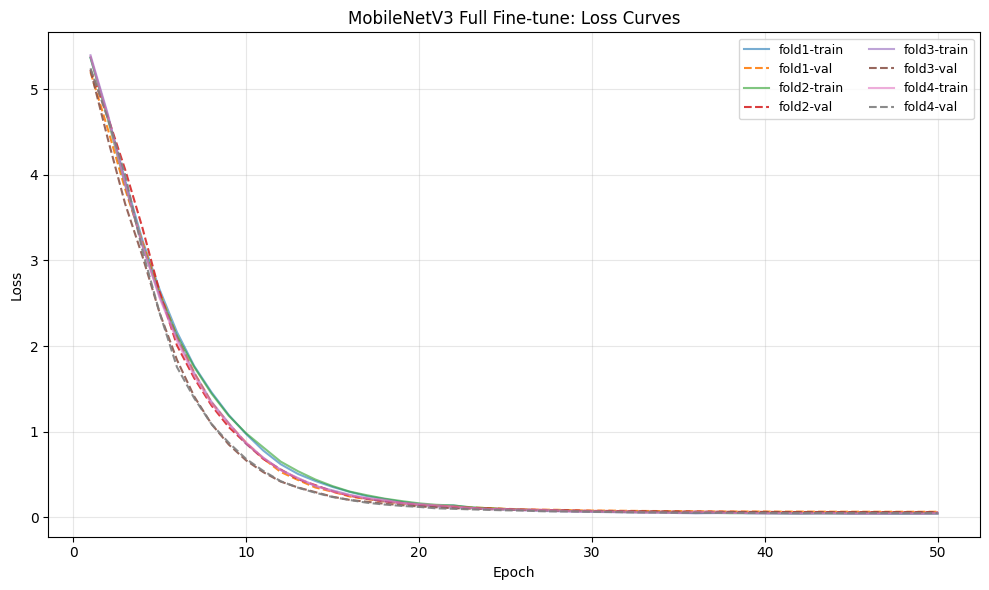

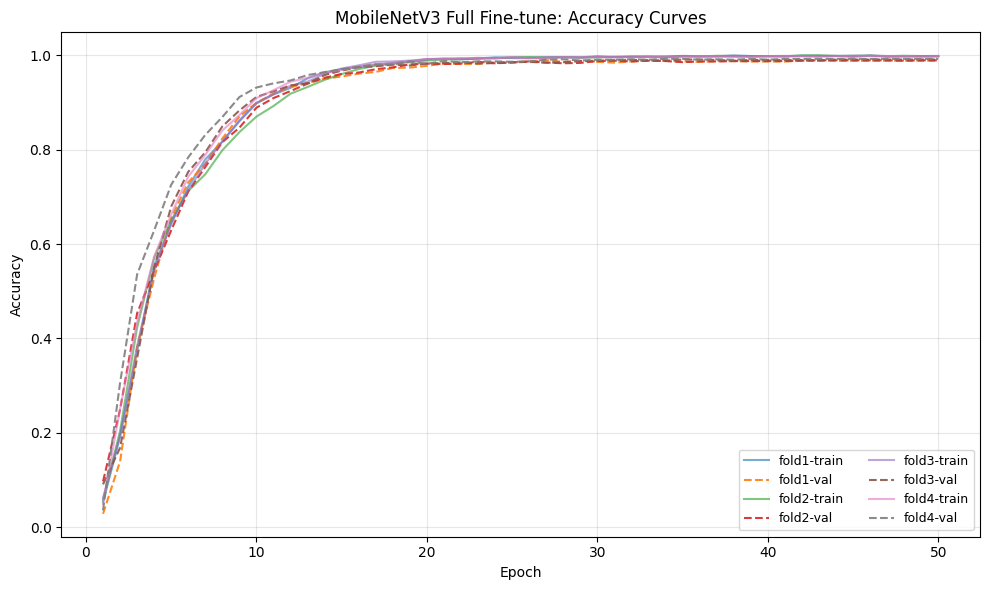

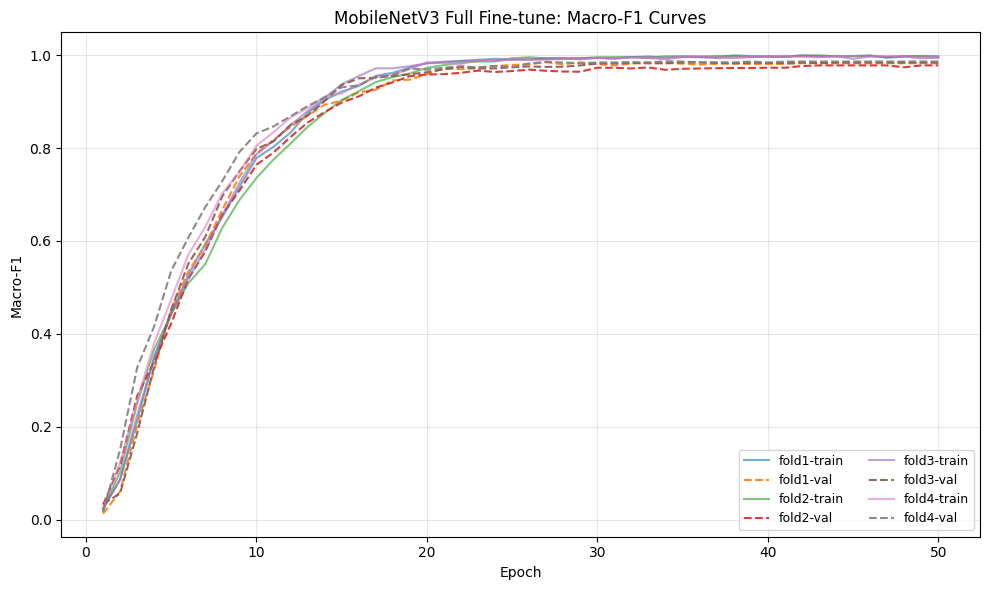

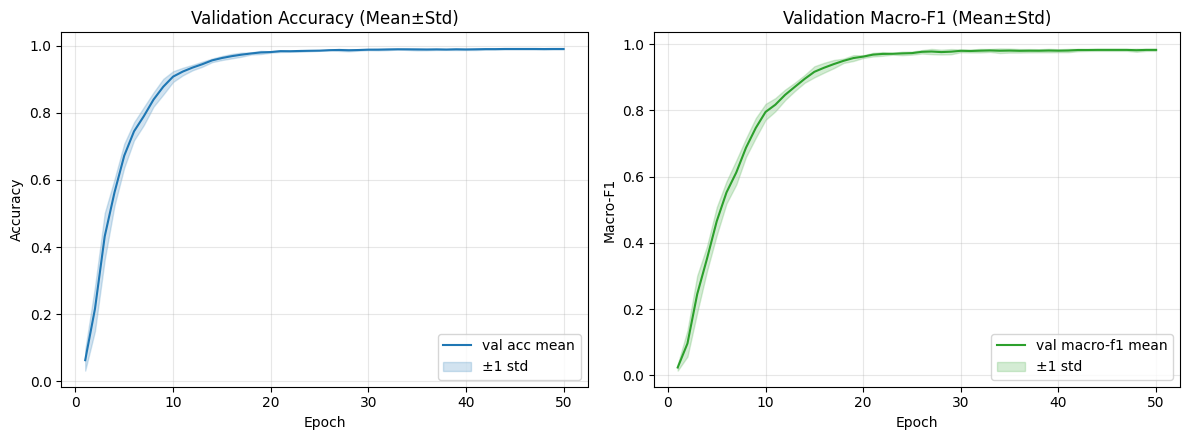

Figures saved to: /scratch/yangximing/code/ass3-exp/results/full_finetune_mobilenetv3_224_fc268/figures


In [6]:
# ========== Step 6: curve plots ==========

fig_dir = save_dir / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)

# 1) Loss curves
plt.figure(figsize=(10, 6))
for fold_id, h in all_fold_histories.items():
    plt.plot(h['epoch'], h['train_loss'], alpha=0.6, label=f'fold{fold_id}-train')
    plt.plot(h['epoch'], h['val_loss'], alpha=0.9, linestyle='--', label=f'fold{fold_id}-val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MobileNetV3 Full Fine-tune: Loss Curves')
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(fig_dir / 'loss_curves_all_folds.png', dpi=200)
plt.show()

# 2) Accuracy curves
plt.figure(figsize=(10, 6))
for fold_id, h in all_fold_histories.items():
    plt.plot(h['epoch'], h['train_acc'], alpha=0.6, label=f'fold{fold_id}-train')
    plt.plot(h['epoch'], h['val_acc'], alpha=0.9, linestyle='--', label=f'fold{fold_id}-val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MobileNetV3 Full Fine-tune: Accuracy Curves')
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(fig_dir / 'accuracy_curves_all_folds.png', dpi=200)
plt.show()

# 3) Macro-F1 curves
plt.figure(figsize=(10, 6))
for fold_id, h in all_fold_histories.items():
    plt.plot(h['epoch'], h['train_macro_f1'], alpha=0.6, label=f'fold{fold_id}-train')
    plt.plot(h['epoch'], h['val_macro_f1'], alpha=0.9, linestyle='--', label=f'fold{fold_id}-val')
plt.xlabel('Epoch')
plt.ylabel('Macro-F1')
plt.title('MobileNetV3 Full Fine-tune: Macro-F1 Curves')
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(fig_dir / 'macro_f1_curves_all_folds.png', dpi=200)
plt.show()

# 4) Mean val curves across folds
epochs = all_fold_histories[1]['epoch'].to_numpy()
val_acc_stack = np.stack([h['val_acc'].to_numpy() for h in all_fold_histories.values()], axis=0)
val_f1_stack = np.stack([h['val_macro_f1'].to_numpy() for h in all_fold_histories.values()], axis=0)

acc_mean = val_acc_stack.mean(axis=0)
acc_std = val_acc_stack.std(axis=0)
f1_mean = val_f1_stack.mean(axis=0)
f1_std = val_f1_stack.std(axis=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
ax[0].plot(epochs, acc_mean, color='tab:blue', label='val acc mean')
ax[0].fill_between(epochs, acc_mean - acc_std, acc_mean + acc_std, color='tab:blue', alpha=0.2, label='±1 std')
ax[0].set_title('Validation Accuracy (Mean±Std)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(epochs, f1_mean, color='tab:green', label='val macro-f1 mean')
ax[1].fill_between(epochs, f1_mean - f1_std, f1_mean + f1_std, color='tab:green', alpha=0.2, label='±1 std')
ax[1].set_title('Validation Macro-F1 (Mean±Std)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Macro-F1')
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.savefig(fig_dir / 'val_mean_std_curves.png', dpi=200)
plt.show()

print('Figures saved to:', fig_dir)
